In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path
from IPython import display

# 当前目录
current_dir = os.path.dirname(os.path.abspath('__file__'))
# 上一级目录
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
# 上两级目录
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)

from data import get_dataset, make_gym_dataset, sample_gym, hamiltonian_fn
from nn_models import MLPAutoencoder, MLP
from hnn import HNN, PixelHNN
from utils import make_gif, L2_loss, integrate_model

# config

In [2]:
DPI = 300
LINE_SEGMENTS = 20
LINE_WIDTH = 2
FORMAT = 'pdf'
save_dir = './'

def get_args():
    return {'input_dim': 2*784,
         'hidden_dim': 200,
         'latent_dim': 2,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'print_every': 200,
         'num_frames': 400,
         'name': 'pixels',
         'seed': 0,
         'save_dir': save_dir,
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# infer

Successfully loaded data from .//pendulum-pixels-dataset.pkl


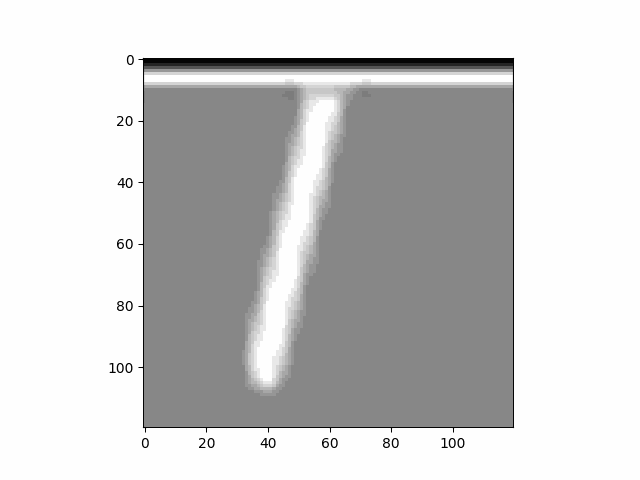

In [3]:
from data import get_dataset, make_gym_dataset, sample_gym, hamiltonian_fn
from utils import make_gif, L2_loss, integrate_model

args = ObjectView(get_args())

# load dataset
data = get_dataset('pendulum', args.save_dir, verbose=False)
side = data['meta']['side']
trials = data['meta']['trials']
timesteps = data['meta']['timesteps']

frames = data['pixels'][:,:side**2].reshape(-1, side, side)[:args.num_frames]
name = '{}-dataset'.format(args.name)
gifname = make_gif(frames, args.fig_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

In [4]:
trials

200

In [5]:
def load_model(args, baseline=False):
#     args.latent_dim = 4 if baseline else 8
    autoencoder = MLPAutoencoder(args.input_dim, args.hidden_dim,
                                     args.latent_dim, nonlinearity='relu')
    model = PixelHNN(args.latent_dim, args.hidden_dim, autoencoder,
                     nonlinearity=args.nonlinearity, baseline=baseline)

    case = 'baseline' if baseline else 'hnn'
    # path = "{}/pixels-pixels-{}.tar".format(args.save_dir, case)
    path = "../pixels-pixels-{}.tar".format(case)
    model.load_state_dict(torch.load(path))
    return model

hnn_model = load_model(args, baseline=False)
hnn_model

PixelHNN(
  (autoencoder): MLPAutoencoder(
    (linear1): Linear(in_features=1568, out_features=200, bias=True)
    (linear2): Linear(in_features=200, out_features=200, bias=True)
    (linear3): Linear(in_features=200, out_features=200, bias=True)
    (linear4): Linear(in_features=200, out_features=2, bias=True)
    (linear5): Linear(in_features=2, out_features=200, bias=True)
    (linear6): Linear(in_features=200, out_features=200, bias=True)
    (linear7): Linear(in_features=200, out_features=200, bias=True)
    (linear8): Linear(in_features=200, out_features=1568, bias=True)
  )
  (hnn): HNN(
    (differentiable_model): MLP(
      (linear1): Linear(in_features=2, out_features=200, bias=True)
      (linear2): Linear(in_features=200, out_features=200, bias=True)
      (linear3): Linear(in_features=200, out_features=2, bias=False)
    )
  )
)

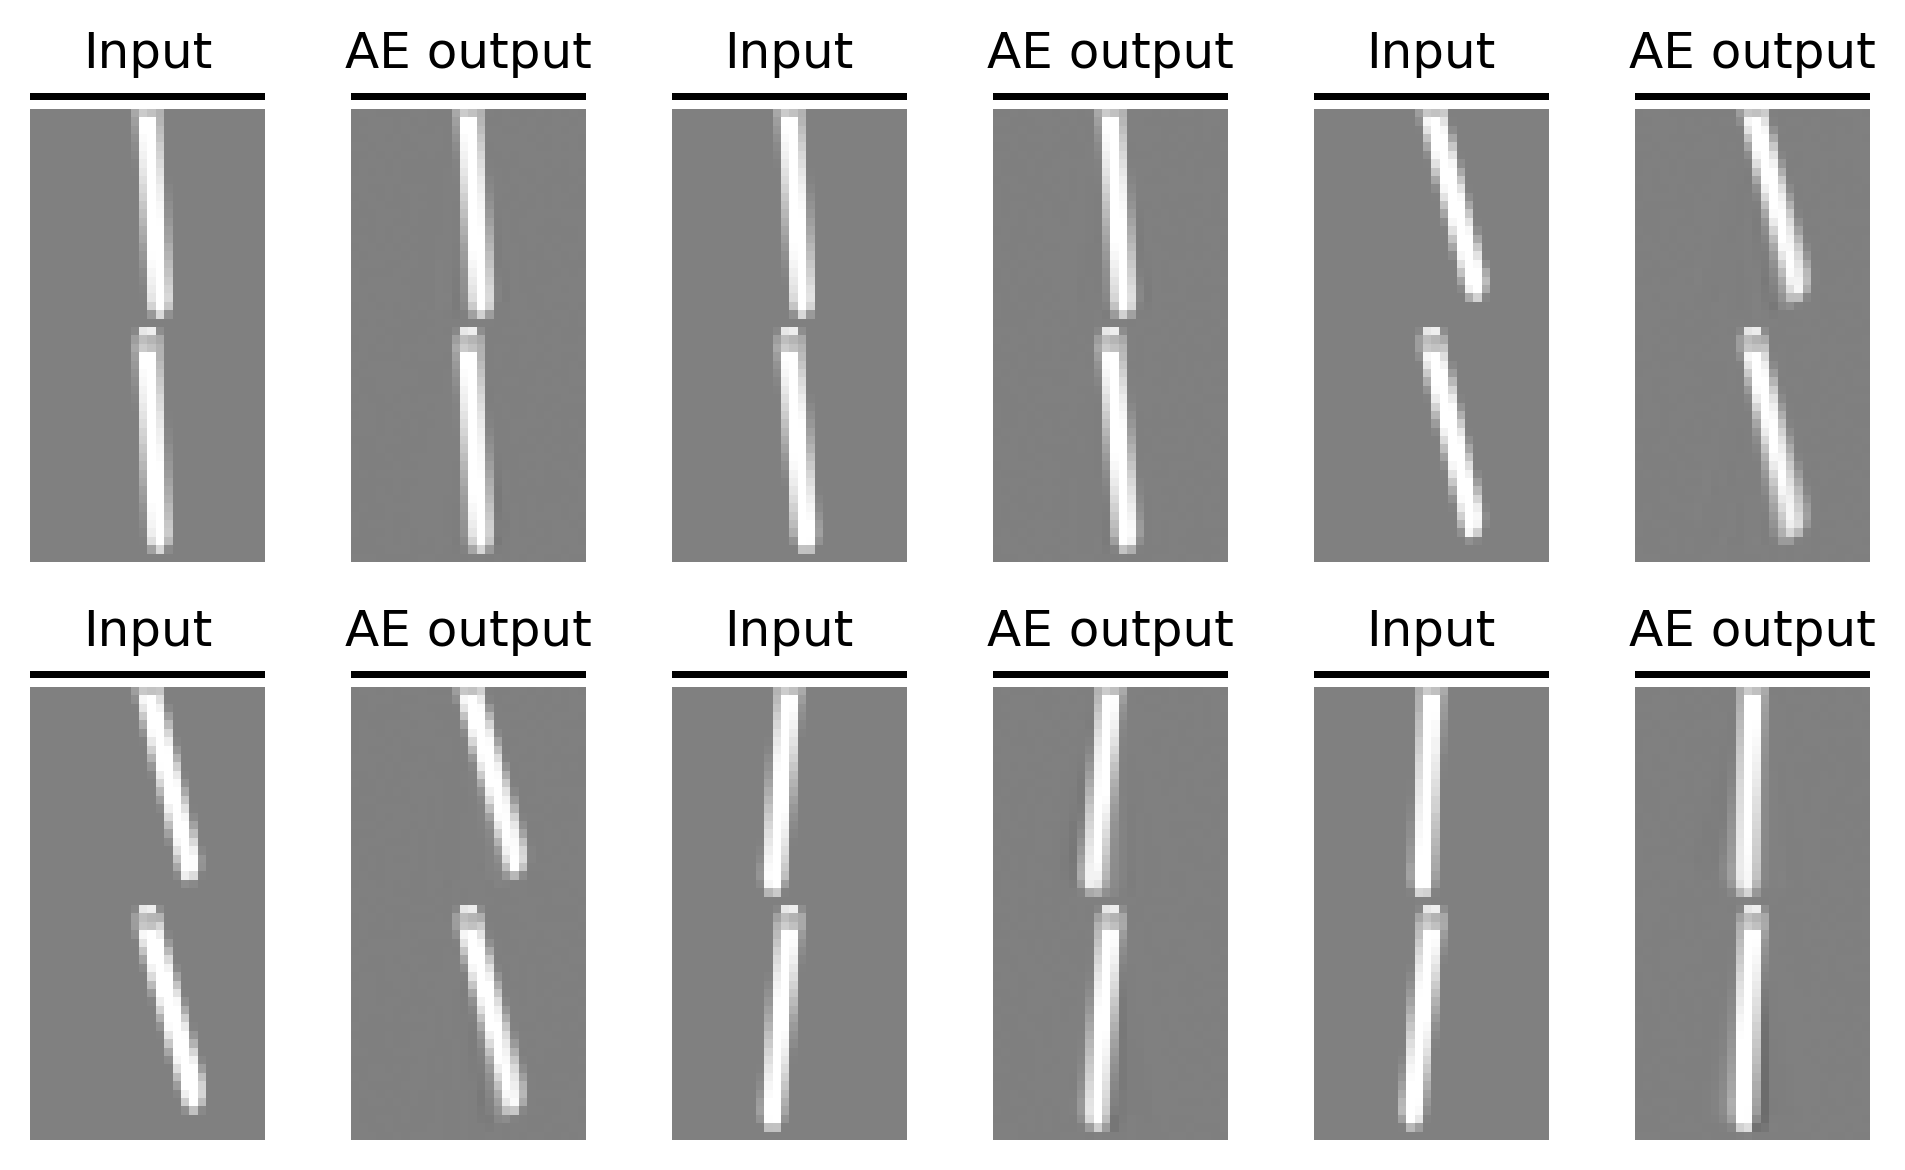

In [6]:
import matplotlib.pyplot as plt

rows, cols = 2, 3
fig = plt.figure(figsize=[1.1*2*cols, 2*rows], dpi=DPI)

x = torch.tensor( data['pixels'], dtype=torch.float32)
x_next = torch.tensor( data['next_pixels'], dtype=torch.float32)

ixs = torch.randperm(x.shape[0])[:2*rows*cols]
bx, bx_next = x[ixs], x_next[ixs]
bx_hat_next = hnn_model.autoencoder(bx_next)

for r in range(rows):
  for c in range(cols):
    ix = r*2*cols + 2*c
    
    plt.subplot(rows, 2*cols, ix + 1)
    im = bx_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("Input")
    
    
    plt.subplot(rows, 2*cols, ix + 2)
    im = bx_hat_next[ix].detach().numpy().reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("AE output")
    
plt.tight_layout() ; plt.show()
fig.savefig('{}/autoencoder-hnn.{}'.format(args.fig_dir, FORMAT))

In [7]:
np.max( data['pixels'])

0.5529411764705883

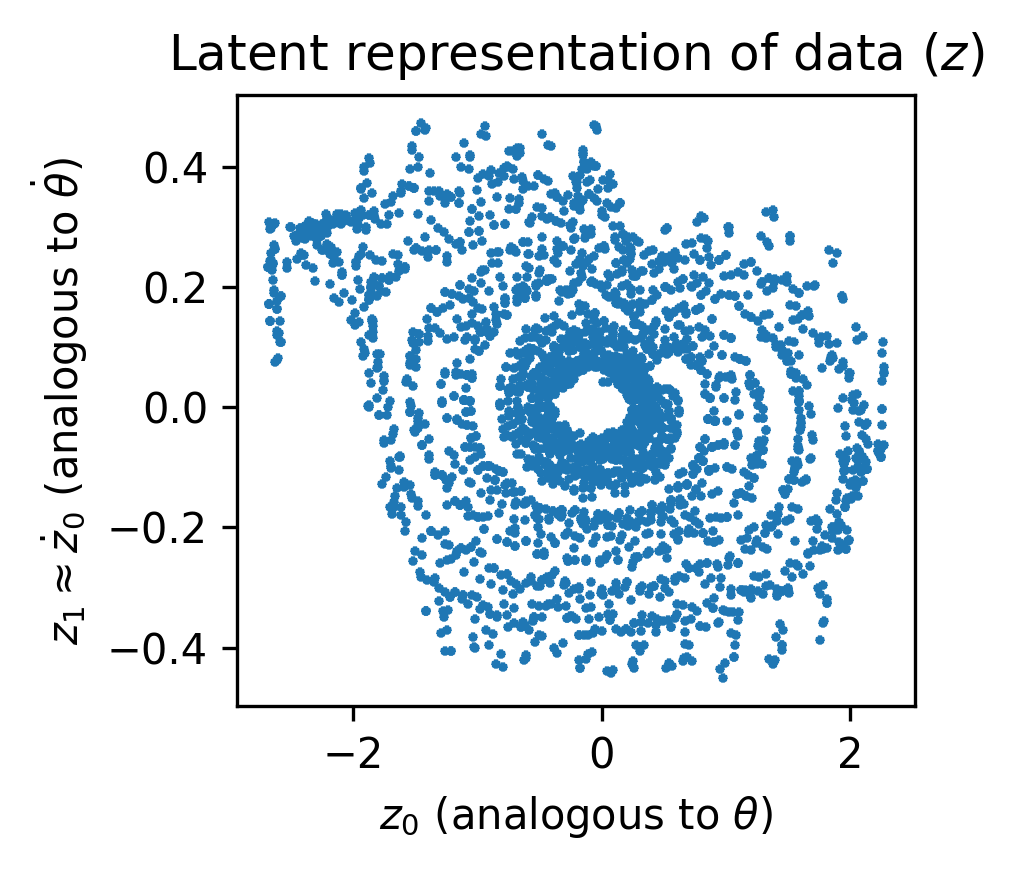

In [8]:
k = 3000
fig = plt.figure(figsize=(3.25, 3), facecolor='white', dpi=DPI)
ax = fig.add_subplot(1, 1, 1, frameon=True)
latents = hnn_model.encode(x).detach().numpy()
plt.plot(latents[:k,0], latents[:k,1], '*', markersize=2)

ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("Latent representation of data ($z$)")

plt.tight_layout() ; plt.show()
fig.savefig('{}/latents-hnn.{}'.format(args.fig_dir, FORMAT))

In [9]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

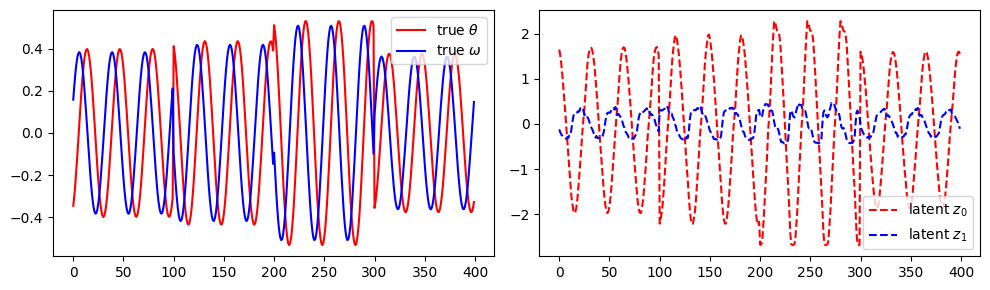

In [10]:
k = 400
fig = plt.figure(figsize=[10,3], dpi=100)
plt.subplot(1,2,1)
plt.plot(data['coords'][:k,0], "r-", label='true $\\theta$')    # ground truth coordinates (theta and omega)
plt.plot(data['coords'][:k,1], "b-", label='true $\omega$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(latents[:k,0], "r--", label='latent $z_0$')   # learned by autoencoder (in an unsupervised manner)
plt.plot(latents[:k,1], "b--", label='latent $z_1$')
plt.legend()

plt.tight_layout() ; plt.show()

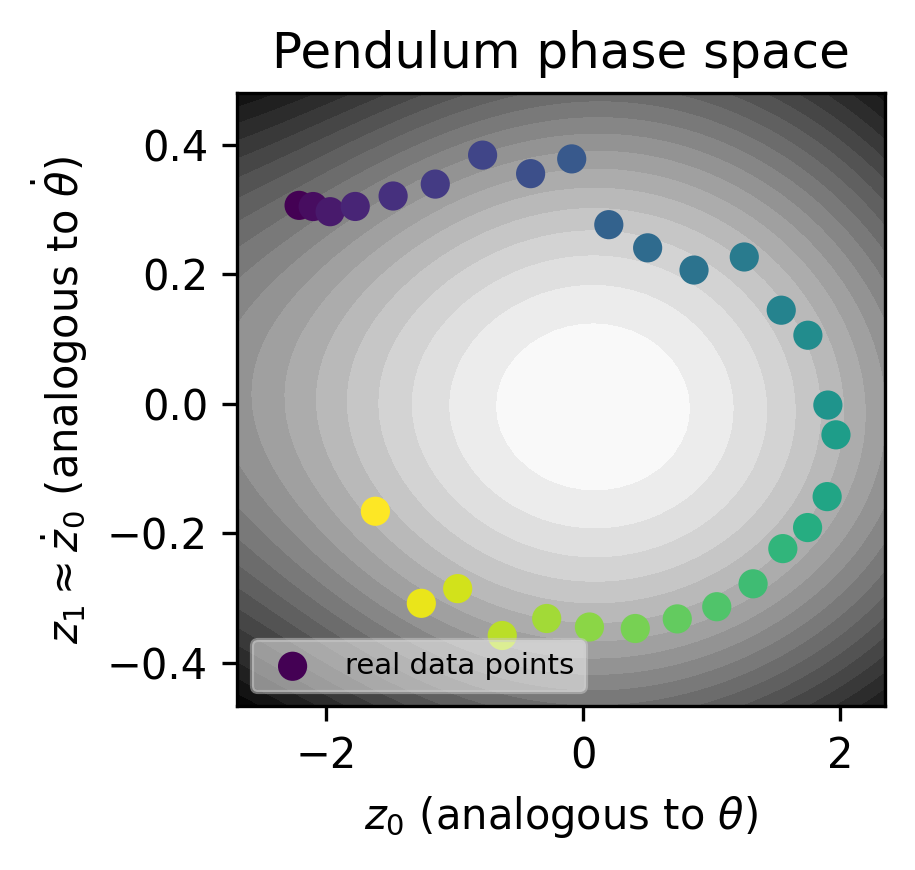

In [11]:
# set domain
gs = 50
xmin, xmax = latents[:,0].min(), latents[:,0].max()
vmin, vmax = latents[:,1].min(), latents[:,1].max()

# feed through HNN model
gX, gV = np.meshgrid(np.linspace(xmin, xmax, gs), np.linspace(vmin, vmax, gs))
np_mesh_inputs = np.stack([gX.flatten(), gV.flatten()]).T
mesh_inputs = torch.tensor( np_mesh_inputs, requires_grad=True, dtype=torch.float32)

# get scalar fields
F1, F2 = hnn_model.hnn(mesh_inputs)
np_F1, np_F2 = F1.data.numpy().reshape(gs,gs), F2.data.numpy().reshape(gs,gs)

# plot phase space
fig = plt.figure(figsize=(3.15, 3), facecolor='white', dpi=DPI)
ax = fig.add_subplot(1, 1, 1, frameon=True)
plt.contourf(gX, gV, np_F2, cmap='gray_r', levels=20)
ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("Pendulum phase space")

# plot data points
k = 30 ; t = 100
c = np.linspace(0, 10, k)
plt.scatter(latents[:,0][t:t+k], latents[:,1][t:t+k], c=c, cmap='viridis', label='real data points')

plt.legend(fancybox=True, framealpha=.5, fontsize=7)
plt.tight_layout() ; plt.show()
fig.savefig('{}/learned-phase-space.{}'.format(args.fig_dir, FORMAT))

/home/lbu/anaconda3/envs/py396/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


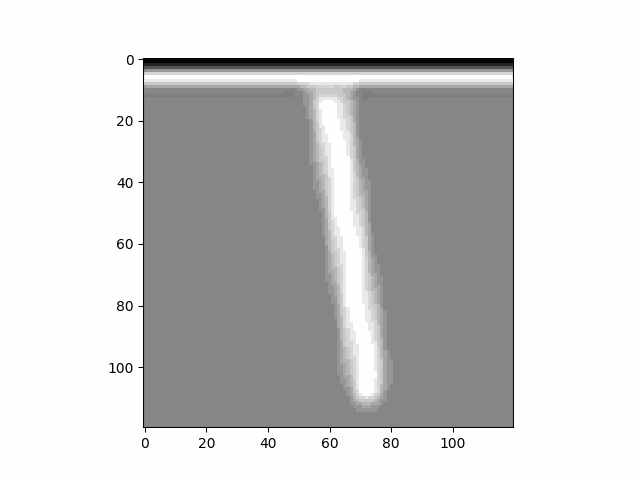

In [12]:
num_frames = 200
test_data = make_gym_dataset(seed=1, timesteps=num_frames+3, trials=1, test_split=0,
                             max_angle=np.pi/10, min_angle=np.pi/11)

# load dataset
side = test_data['meta']['side']

real_pixel_traj = test_data['pixels'][:,:side**2].reshape(-1, side, side)[:num_frames]
name = '{}-truth'.format(args.name)
gifname = make_gif(real_pixel_traj, args.fig_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

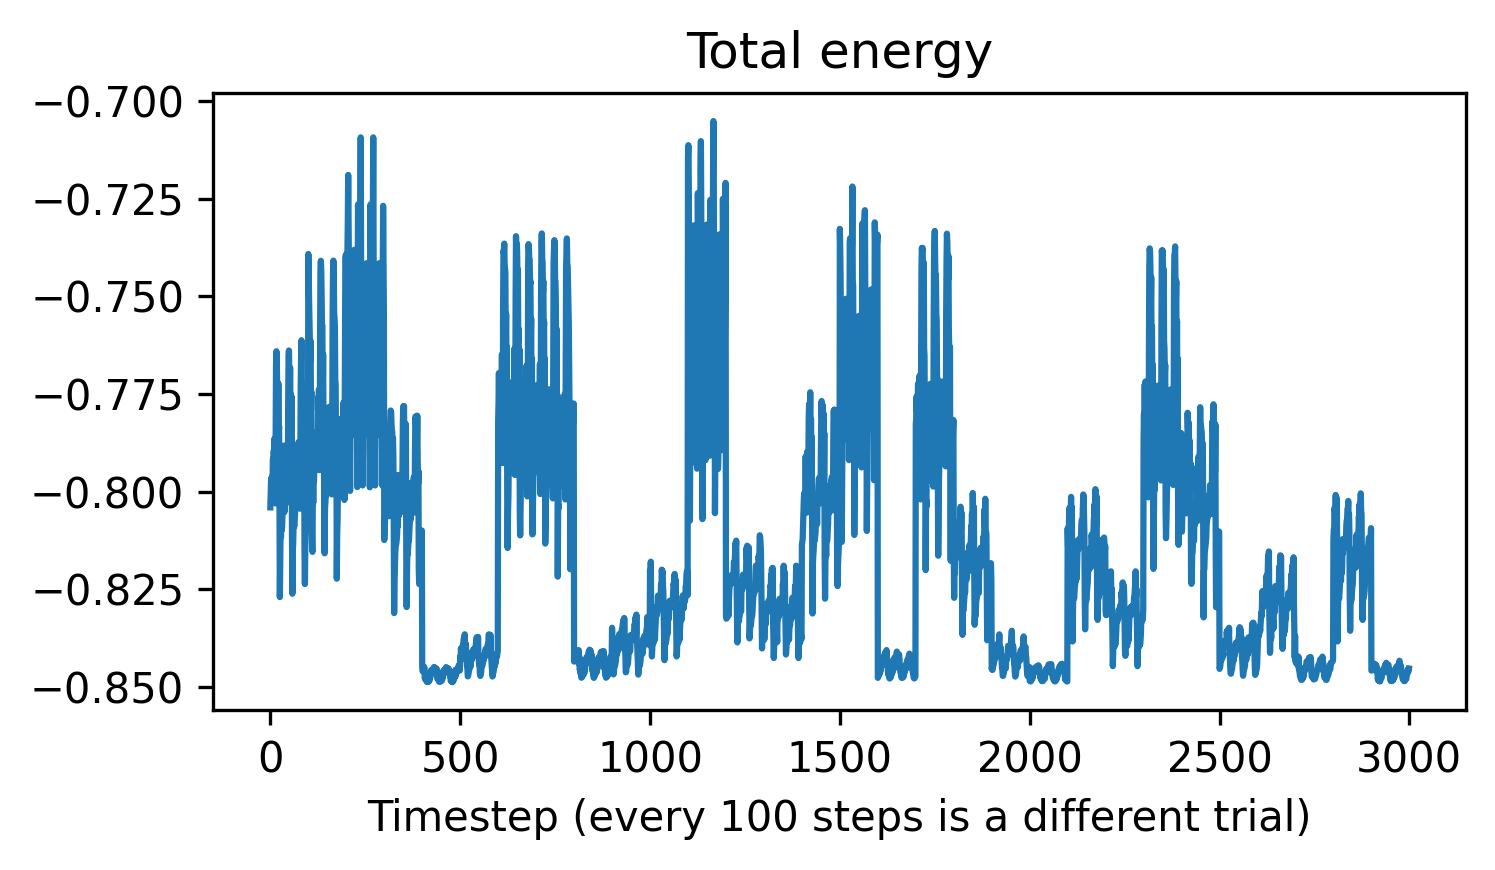

In [13]:
k = 3000
fig = plt.figure(figsize=[5,3], dpi=DPI)

z_values = hnn_model.encode(x[:k])
F1, F2 = hnn_model.hnn(z_values)
energy = F2.detach().numpy()
plt.plot(energy)
plt.title("Total energy")
plt.xlabel("Timestep (every {} steps is a different trial)".format(timesteps))
plt.tight_layout() ; plt.show()
fig.savefig('{}/total-energy.{}'.format(args.fig_dir, FORMAT))

In [19]:
# get initial values of latents
x0 = torch.tensor( test_data['pixels'][0:1], dtype=torch.float32)
hnn_y0 = hnn_model.encode(x0).detach().numpy().squeeze()

# integrator settings
t_span = [0, 0.98*num_frames]
point_density = num_frames / t_span[-1]
t_eval = np.linspace(t_span[0], t_span[1], num_frames)

# integrate models
# Here we don't compute t_eval[0] because it's the initial state of the system
#   and thus is already known.
hnn_traj = integrate_model(hnn_model, t_span, hnn_y0, t_eval=t_eval[1:])

tensor([-3.2510e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.2557e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.2536e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.2548e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.2611e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.2622e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.2636e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.2636e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.2883e-38], grad_fn=<SelectBackward0>) tensor([-0.7961], grad_fn=<SelectBackward0>)
tensor([-3.2993e-38], grad_fn=<SelectBackward0>) tensor([-0.7962], grad_fn=<SelectBackward0>)
tensor([-3.3510e-38], grad_fn=<SelectBackward0>) tensor([-0.

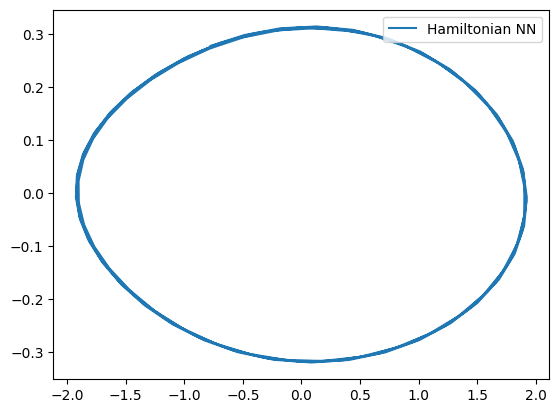

In [21]:
plt.plot(hnn_traj['y'][0], hnn_traj['y'][1], label='Hamiltonian NN')
plt.legend(loc='upper right')
plt.show()

In [24]:
# get initial values of latents
hnn_zs = torch.tensor( hnn_traj['y'].T, dtype=torch.float32)

hnn_pixel_traj = hnn_model.decode(hnn_zs).detach().numpy()

_hnn_pixel_traj = hnn_pixel_traj[:,:side**2].reshape(-1, side, side)

# set initial values
x0 = real_pixel_traj[0:1]
_hnn_pixel_traj = np.concatenate([x0, _hnn_pixel_traj],axis=0)

trajs = np.concatenate([real_pixel_traj,
                        _hnn_pixel_traj], axis=-1)

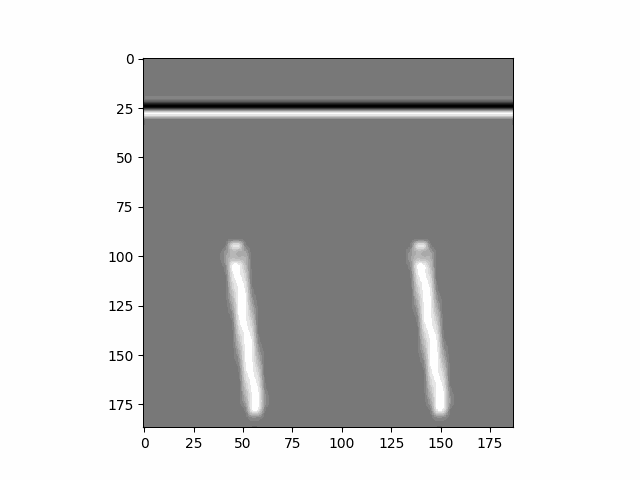

In [28]:
from PIL import Image, ImageDraw, ImageSequence, ImageFont
import torch, sys, io

# add whitespace to top
frac = 1/4.
padding = int(frac*side)
zero_tensor = np.zeros_like(trajs)[:,:padding]
trajs = np.concatenate([zero_tensor, trajs], axis=1)

# make and save a GIF
name = '{}-compare'.format(args.name)
pixels = [int((1+frac)*150), 3*150] # dimensions of GIF in pixels
gifname = make_gif(trajs, args.fig_dir, name=name, duration=1e-1, pixels=pixels, divider=padding)

# reload GIF and add text labels to it
im = Image.open(gifname)
frames = []
# Loop over each frame in the animated image
for frame in ImageSequence.Iterator(im):
    # Draw the text on the frame
    d = ImageDraw.Draw(frame)
    # font = ImageFont.truetype("/Library/Fonts/Arial.ttf", 18)
    d.text((33,7), "Ground truth")
    d.text((175,7), "Baseline NN")
    d.text((310,7), "Hamiltonian NN")
    del d

    # Saving the image without 'save_all' will turn it into a single frame image, and we can then re-open it
    # To be efficient, we will save it to a stream, rather than to file
    b = io.BytesIO()
    frame.save(b, format="GIF")
    frame = Image.open(b)

    # Then append the single frame image to a list of frames
    frames.append(frame)
# Save the frames as a new image
name = "{}/{}-compare-labeled.gif".format(args.fig_dir, args.name)
frames[0].save(name, save_all=True, append_images=frames[1:])

display.Image(filename=name, width=400)